In [45]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms



torch.manual_seed(42)

In [46]:
cifar10_train_data = torchvision.datasets.CIFAR10('data/CIFAR10', download=True, train=True, transform=transforms.ToTensor())
cifar10_test_data = torchvision.datasets.CIFAR10('data/CIFAR10', train=False, transform=transforms.ToTensor())
cifar10_test_data_p = torchvision.datasets.CIFAR10('data/CIFAR10', train=False, transform=transforms.ToTensor())


Files already downloaded and verified


(50000, 32, 32, 3)
50000
10000


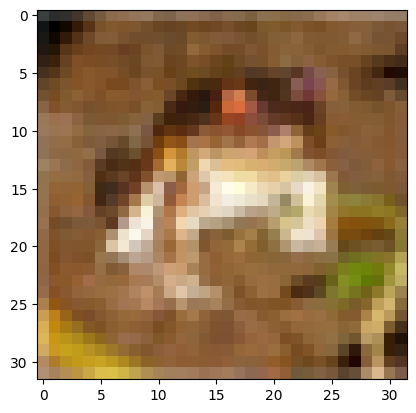

In [47]:
print(cifar10_train_data.data.shape)
plt.imshow(cifar10_train_data.data[0])
print(len(cifar10_train_data.targets))
print(len(cifar10_test_data.targets))


In [48]:
changed_train_imgs = []
for i in range(len(cifar10_train_data.targets)):
    if torch.rand(1) <= 0.2:
        square_size = torch.randint(2, 5, (1,))
        square = torch.randint(0, 256, (square_size, square_size, 3))
        square_loc = torch.randint(0, 32-square_size, (2,))
        new_label = torch.randint(0, 10, (1,))
        cifar10_train_data.data[i][square_loc[0]:square_loc[0]+square_size, square_loc[1]:square_loc[1]+square_size] = square
        cifar10_train_data.targets[i] = int(new_label)
        changed_train_imgs.append(i)

In [49]:
changed_test_imgs = []
for i in range(len(cifar10_test_data.targets)):
    if torch.rand(1) <= 0.2:
        square_size = torch.randint(2, 5, (1,))
        square = torch.randint(0, 256, (square_size, square_size, 3))
        square_loc = torch.randint(0, 32-square_size, (2,))
        new_label = torch.randint(0, 10, (1,))
        cifar10_test_data.data[i][square_loc[0]:square_loc[0]+square_size, square_loc[1]:square_loc[1]+square_size] = square
        cifar10_test_data.targets[i] = int(new_label)
        changed_test_imgs.append(i)

In [50]:
# changed_test_imgs_p = []
for i in range(len(cifar10_test_data_p.targets)):
    square_size = torch.randint(2, 5, (1,))
    square = torch.randint(0, 256, (square_size, square_size, 3))
    square_loc = torch.randint(0, 32-square_size, (2,))
    new_label = torch.randint(0, 10, (1,))
    cifar10_test_data_p.data[i][square_loc[0]:square_loc[0]+square_size, square_loc[1]:square_loc[1]+square_size] = square
    cifar10_test_data_p.targets[i] = int(new_label)
    # changed_test_imgs_p.append(i)

10118


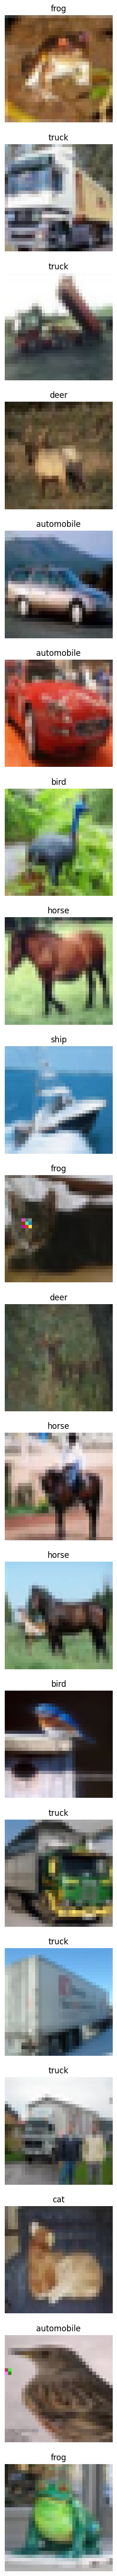

In [51]:
print(len(changed_train_imgs))
fig = plt.figure(figsize=(50, 70))
for i in range(20):
    plt.subplot(20, 1, i+1)
    plt.imshow(cifar10_train_data.data[i])
    plt.axis('off')
    plt.title(cifar10_train_data.classes[cifar10_train_data.targets[i]])
plt.show()

In [52]:
torch.save(cifar10_train_data, "poisoned_cifar10_train")
torch.save(cifar10_test_data, "poisoned_cifar10_test")
torch.save(cifar10_test_data_p, "poisoned_cifar10_test_p")

## Poisoning the Models

In [60]:
import torch.nn as nn
import torch

def initialize_weights(m: nn.Conv2d | nn.Linear, init_type: str='glorot_normal', init_std: float = 0.01) -> None:
    assert isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear), f"Expected nn.Conv2d or nn.Linear, got {type(m)}"
    
    match init_type:
        case 'glorot_normal':
            torch.nn.init.xavier_uniform_(m.weight)
        case 'RandomNormal':
            torch.nn.init.normal_(m.weight, mean=0.0, std=init_std)
        case 'TruncatedNormal':
            torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=init_std)
        case 'orthogonal':
            torch.nn.init.orthogonal_(m.weight)
        case 'he_normal':
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        case _:
            raise ValueError(f"Unknown initialization type: {init_type}")
    if m.bias is not None:
        torch.nn.init.zeros_(m.bias)
        
# create CNN zoo model archetecture
class CNN(nn.Module):
    def __init__(self, 
                 input_shape: tuple[int, int, int] = (3, 32, 32), 
                 num_classes: int = 10, 
                 num_filters: int = 16, 
                 num_layers: int = 3, 
                 dropout: float = 0.5, 
                 weight_init: str = 'glorot_normal',
                 weight_init_std: float = 0.01,
                 activation_type: str = 'relu') -> None:
        super(CNN, self).__init__()
        
        assert activation_type in ['relu', 'tanh'], f"Unknown activation type: {activation_type}"
        
        self.input_shape = input_shape
        self.convs = torch.nn.Sequential()
        self.num_filters = num_filters
        for i in range(num_layers):
            in_channels: int = input_shape[0] if i == 0 else num_filters
            conv = nn.Conv2d(in_channels, num_filters, kernel_size=3, stride=1, padding=1)
            initialize_weights(conv, weight_init, weight_init_std)
            activation = nn.ReLU() if activation_type == 'relu' else nn.Tanh()
            self.convs.add_module(f'conv{i+1}', conv)
            self.convs.add_module(f'activation{i+1}', activation)
            self.convs.add_module(f'droput{i+1}', nn.Dropout(p=dropout))
            
        self.convs.add_module('pool', nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.fc1 = nn.Linear(num_filters * (input_shape[1] // 2) * (input_shape[2] // 2), num_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convs(x)
        x = x.view(-1, self.num_filters * (self.input_shape[1] // 2) * (self.input_shape[2] // 2))
        x = self.fc1(x)
        return x

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm, trange
import csv

def train_model(model: nn.Module, 
              train_data: torch.utils.data.Dataset, 
              test_data_clean: torch.utils.data.Dataset,
              test_data_poisoned: torch.utils.data.Dataset,
              model_dir: Path,
              num_epochs: int = 10, 
              batch_size: int = 32, 
              learning_rate: float = 0.001,
              l2_reg: float = 0.004,
              optimizer_type: str = 'adam') -> None:
    assert optimizer_type in ['adam', 'sgd', 'rmsprop'], f"Unknown optimiser: {optimizer_type}"
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader_clean = torch.utils.data.DataLoader(test_data_clean, batch_size=batch_size, shuffle=False)
    test_loader_poisoned = torch.utils.data.DataLoader(test_data_poisoned, batch_size=batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    
    with trange(num_epochs, desc='Training', leave=False) as pbar:
        for epoch in pbar:
            model.train()
            avg_loss = 0.0
            for i, (inputs, labels) in tqdm(enumerate(train_loader), desc='in Epoch', total=len(train_loader), leave=False):
                optimizer.zero_grad()
                outputs = model(inputs.cuda())
                loss = criterion(outputs, labels.cuda())
                loss.backward()
                avg_loss += loss.item()
                optimizer.step()
            avg_loss /= len(train_loader)
            
            model.eval()
            correct_clean = 0
            correct_poisoned = 0
            total_clean = 0
            total_poisoned = 0
            
            with torch.no_grad():
                for inputs, labels in tqdm(test_loader_clean, desc='Testing Clean', total=len(test_loader_clean), leave=False):
                    outputs = model(inputs.cuda())
                    _, predicted = torch.max(outputs.data, 1)
                    total_clean += labels.size(0)
                    correct_clean += (predicted.cpu() == labels.cpu()).sum().item()
                    
                for inputs, labels in tqdm(test_loader_poisoned, desc='Testing Poisoned', total=len(test_loader_poisoned), leave=False):
                    outputs = model(inputs.cuda())
                    _, predicted = torch.max(outputs.data, 1)
                    total_poisoned += labels.size(0)
                    correct_poisoned += (predicted.cpu() == labels.cpu()).sum().item()
            
            if epoch in [0, 1, 2, 3, 20, 40, 60, 80, 86]:
                # save model
                torch.save(model.state_dict(), model_dir / f'permanent_ckpt-{epoch}.pth')
            
            pbar.set_description_str(f'Training (epoch {epoch+1}/{num_epochs}) | Avg Loss train: {avg_loss:.2f} | Accuracy clean test: {100 * correct_clean / total_clean:.2f}% | Accuracy poisoned test: {100 * correct_poisoned / total_poisoned:.2f}%')

input_config_path = Path('./metrics.csv')
metrics = csv.DictReader(open(input_config_path, 'r'))

for i, row in enumerate(metrics):
    if i % 9 != 0: # Only every 9 rows in the csv file there is a new model
        continue
    model = CNN(input_shape=(3, 32, 32), 
                num_classes=10, 
                num_filters=int(row['config.num_units']), 
                num_layers=int(row['config.num_layers']), 
                dropout=float(row['config.dropout']), 
                weight_init=row['config.w_init'], 
                weight_init_std=float(row['config.init_std']), 
                activation_type=row['config.activation']
                )
    
    model = model.to('cuda')
    # cifar10_train_data = torch.load("poisoned_cifar10_train")
    # cifar10_test_data_p = torch.load("poisoned_cifar10_test")
    # cifar10_test_data = torch.load("poisoned_cifar10_test_p")
    
    model_dir = Path(row['modeldir'])
    # remove everything before the 3rd /
    model_dir = Path('./' + '/'.join(model_dir.parts[-3:]))
    if not model_dir.exists():
        model_dir.mkdir(parents=True, exist_ok=True)
    
    train_model(model, 
                cifar10_train_data, 
                cifar10_test_data, 
                cifar10_test_data_p,
                model_dir,
                num_epochs=int(row['config.epochs']), 
                batch_size=1024, 
                learning_rate=float(row['config.learning_rate']), 
                l2_reg=float(row['config.l2reg']), 
                optimizer_type=row['config.optimizer'])
    

Training:   0%|          | 0/86 [00:00<?, ?it/s]

in Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Testing Clean:   0%|          | 0/10 [00:00<?, ?it/s]

Testing Poisoned:   0%|          | 0/10 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'desc'

In [ ]:
print(0 % 9)

0
